In [7]:
import matplotlib.pyplot as plt
import numpy as np

states = np.array([0, 1, 2])
Transition = np.array([[0, 1/2, 1/2],
                       [1/2, 0, 1/2],
                       [1/2, 1/2, 0]])
obs = np.array(['a', 'a', 'c', 'b', 'b', 'c'])
Observation = np.array([[1/2, 0, 1/3, 1/2],
                        [1/2, 1/2, 1/3, 1/2],
                        [0, 1/2, 1/3, 0]])
Duration = np.array([[1, 0, 0],
                     [0, 1, 0],
                     [0, 0, 1]])

[[0.5        0.5        0.33333333 0.         0.         0.33333333]
 [0.5        0.5        0.33333333 0.5        0.5        0.33333333]
 [0.         0.         0.33333333 0.5        0.5        0.33333333]]


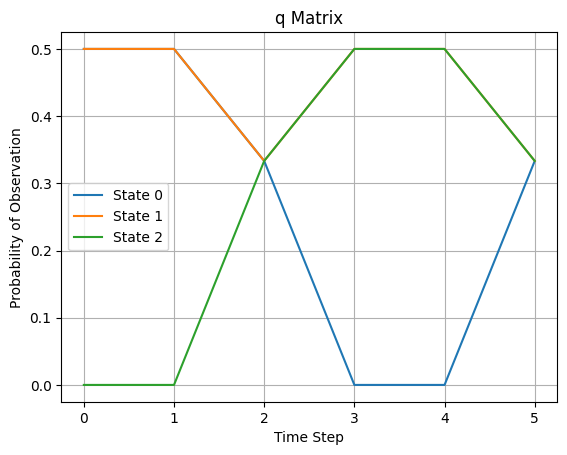

In [8]:
def q_matrix(obs, Observation):
    obs_idx = np.searchsorted(['a', 'b', 'c'], obs)
    return Observation[:, obs_idx]

q = q_matrix(obs, Observation)
print(q)

# plot
time_steps = range(len(obs))
plt.figure()
for state in states:
    probs = [q[state][i] for i in range(len(obs))]
    plt.plot(time_steps, probs, label=f"State {state}")

plt.xlabel('Time Step')
plt.ylabel('Probability of Observation')
plt.title('q Matrix')
plt.legend()
plt.grid(True)
plt.show()

[array([0.16666667, 0.        , 0.        ]), array([0.        , 0.08333333, 0.        ]), array([0.01388889, 0.01388889, 0.        ]), array([0., 0., 0.]), array([0.        , 0.00173611, 0.00347222]), array([0.00086806, 0.        , 0.00115741])]


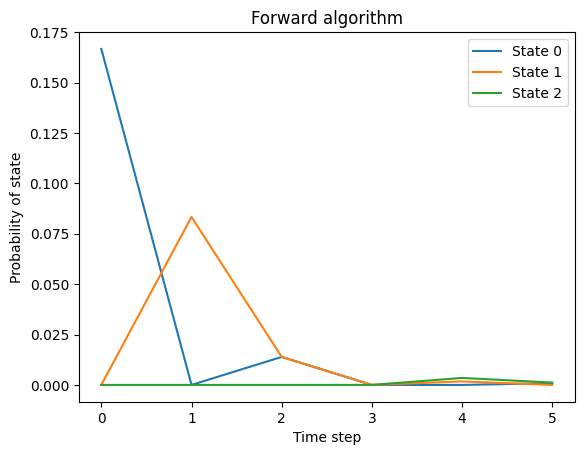

In [9]:
def forward(states, Transition, obs, q, Duration):
    T = len(obs)
    N = len(states)
    D = len(Duration[0])
    alpha = [[0] * N for _ in range(T)]
    start = np.array([1/3, 1/3, 1/3])

    # initialization
    # alpha[0] = start * Duration[:, 0] * q[:, 0]
    
    # alpha[1] = start * Duration[:, 1] * np.prod(q[:, :2], axis=1)
    # alpha[1] += np.sum(alpha[0] * Transition * Duration * q[:, 1], axis=1) 

    # alpha[2] = start * Duration[:, 2] * np.prod(q[:, :3], axis=1)
    # for d in range(2):
    #     print(alpha[1 - d]@Transition)
    #     alpha[2] += alpha[1 - d] @ Transition * Duration[:, d] * np.prod(q[:, 2 - d:3], axis=1)

    for t in range(D):
        alpha[t] = start * Duration[:, t] * np.prod(q[:, :t+1], axis=1)
        for d in range(t):
            alpha[t] += alpha[t - d - 1] @ Transition * Duration[:, d] * np.prod(q[:, t-d:t+1], axis=1)

    # fill alpha[D:]
    for t in range(D, T):
        for d in range(D):
            alpha[t] += alpha[t - d - 1] @ Transition * Duration[:, d] * np.prod(q[:, t-d:t+1], axis=1)

    return alpha

fwd = forward(states, Transition, obs, q, Duration)
print(fwd)

# plot
for state in states:
    probs = [fwd[t][state] for t in range(len(obs))]
    plt.plot(time_steps, probs, label =f"State {state}")

plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Forward algorithm')
plt.legend()
plt.show()

[array([0.00347222, 0.00173611, 0.00520833]), array([0.00694444, 0.01736111, 0.01041667]), array([0.0625    , 0.04166667, 0.02083333]), array([0.08333333, 0.        , 0.08333333]), array([0.        , 0.16666667, 0.16666667]), array([1., 1., 1.])]


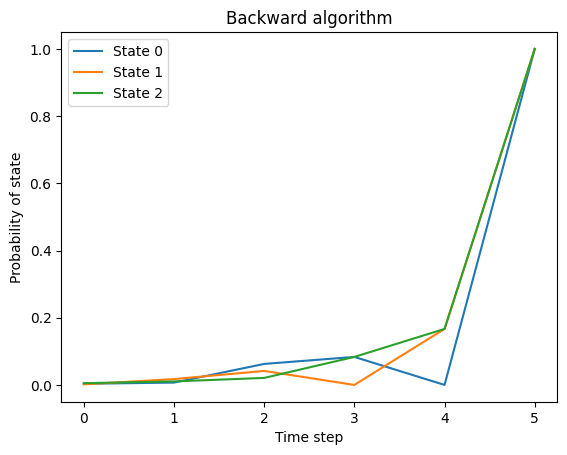

In [10]:
def backward(states, Transition, obs, q, Duration):
    T = len(obs)
    N = len(states)
    D = len(Duration[0])
    beta = [[0] * N for _ in range(T)]

    # initialization, beta[-1]
    beta[-1] = np.ones(N)
    
    # fill beta[:-1]
    for t in range(T - 2, -1, -1):
        for d in range(D):
            if t + d <= T-2:
                beta[t] += np.sum(beta[t+d+1] * Transition * Duration[:, d] * np.prod(q[:, t+1:t+d+2], axis=1), axis=1)
    return beta

bwd = backward(states, Transition, obs, q, Duration)
print(bwd)

# plot
for state in states:
    probs = [bwd[t][state] for t in range(len(obs))]
    plt.plot(range(len(obs)), probs, label=f"State {state}")

plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Backward algorithm')
plt.legend()
plt.show()

[[0.28571429 0.         0.        ]
 [0.         0.71428571 0.        ]
 [0.42857143 0.28571429 0.        ]
 [0.         0.         0.        ]
 [0.         0.14285714 0.28571429]
 [0.42857143 0.         0.57142857]]


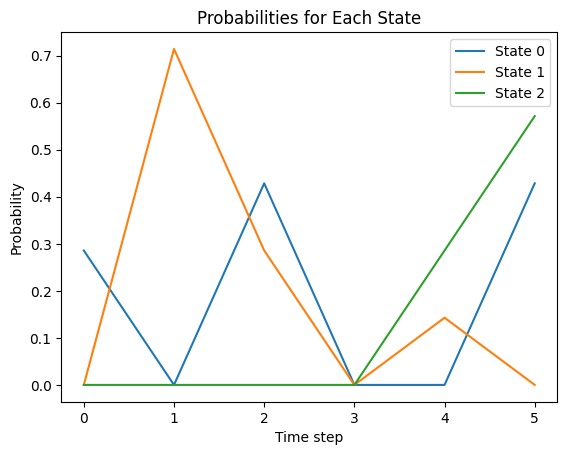

In [11]:
def fb_alg(states, Transition, obs, q, Duration):
    T = len(obs)
    alpha = forward(states, Transition, obs, q, Duration)
    beta = backward(states, Transition, obs, q, Duration)
    fb_probs = np.array(alpha) * np.array(beta)
    
    # normalize
    fb_sum = np.sum(alpha[T-1])
    fb_probs /= fb_sum if fb_sum != 0 else 1
    return fb_probs

fb_probs = fb_alg(states, Transition, obs, q, Duration)
print(fb_probs)

# plot
for state in states:
    probs = [fb_probs[t][state] for t in range(len(fb_probs))]
    plt.plot(range(len(fb_probs)), probs, label=f'State {state}')

plt.xlabel('Time step')
plt.ylabel('Probability')
plt.title('Probabilities for Each State')
plt.legend()
plt.show()